# Importación de las librerias

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, norm, ttest_ind, mannwhitneyu

# Leer los datos

In [72]:
datos = pd.read_csv("REG02_EPHC_ANUAL_2024.csv", sep=";")

/tmp/ipykernel_12036/3740968167.py:1: DtypeWarning: Columns (197,199,202,206,207,208,209,210,211) have mixed types. Specify dtype option on import or set low_memory=False.
  datos = pd.read_csv("REG02_EPHC_ANUAL_2024.csv", sep=";")


In [73]:
datos.head()

,UPM,NVIVI,NHOGA,AÑO,DPTO,AREA,L02,P02,P03,P04,...,ingrevasode,ingrealmuerzode,ipcm,pobrezai,pobnopoi,quintili,decili,quintiai,decilai,informalidad
0,14,3,1,2024,0,1,2,40,1,1,...,0,0,"4035459,49658286",3,0,5,10,5,9,2
1,14,3,1,2024,0,1,6,38,2,1,...,0,0,"4035459,49658286",3,0,5,10,5,9,1
2,14,15,1,2024,0,1,1,78,1,1,...,0,0,"1782061,06870229",3,0,4,7,3,6,
3,14,15,1,2024,0,1,2,77,2,1,...,0,0,"1782061,06870229",3,0,4,7,3,6,
4,14,23,1,2024,0,1,1,32,1,1,...,0,0,"5931717,5572519",3,0,5,10,5,10,1


In [74]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57744 entries, 0 to 57743
Columns: 213 entries, UPM to informalidad
dtypes: int64(25), object(188)
memory usage: 93.8+ MB


# Filtrado de datos

Para el analisis voy a utilizar solo las siguientes columnas

- P06: Sexo
  - 1: Hombre
  - 6: Mujer
- P02: Edad
- PEAA: Ocupación
  - 1: Ocupado
  - 2: Desocupado
  - 3: Inactivo
- E01A: Ingreso mensual Ocupación principal declarado

In [75]:
# Dataframe con solo las columnas necesarias
datos_filtrados = datos[["P06", "P02", "PEAA", "E01A"]]

In [76]:
datos_filtrados.head()

,P06,P02,PEAA,E01A
0,1,40,1,3220000
1,6,38,1,3730373
2,1,78,3,0
3,6,77,3,0
4,1,32,1,5500000


In [77]:
datos_filtrados.shape

(57744, 4)

In [78]:
datos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57744 entries, 0 to 57743
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   P06     57744 non-null  int64 
 1   P02     57744 non-null  int64 
 2   PEAA    57744 non-null  object
 3   E01A    57744 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.8+ MB


## Trabajo sobre los datos

In [79]:
# Renombrar las columnas
datos_filtrados.columns = ["Sexo", "Edad", "Ocupacion", "Ingreso"]

In [80]:
# Convertir la columna Ocupacion a int64

# Reemplazar el ' ' por NaN
datos_filtrados["Ocupacion"] = datos_filtrados["Ocupacion"].replace(" ", np.nan)

# Convertir a número
datos_filtrados["Ocupacion"] = pd.to_numeric(datos_filtrados["Ocupacion"], errors="coerce")

# Eliminar filas con NaN en Ocupacion
datos_filtrados = datos_filtrados.dropna(subset=["Ocupacion"])

# Pasar de float64 a int64
datos_filtrados["Ocupacion"] = datos_filtrados["Ocupacion"].astype("int64")

/tmp/ipykernel_12036/857654796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados["Ocupacion"] = datos_filtrados["Ocupacion"].replace(" ", np.nan)
/tmp/ipykernel_12036/857654796.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_filtrados["Ocupacion"] = pd.to_numeric(datos_filtrados["Ocupacion"], errors="coerce")


In [82]:
# Seleccionar solo las personas ocupadas, es decir, Ocupacion = 1
datos_filtrados = datos_filtrados[datos_filtrados["Ocupacion"] == 1]

In [83]:
# Ahora solo hay personas ocupas
datos_filtrados["Ocupacion"].unique()

array([1])

In [84]:
# Convertir Ingreso a int64
datos_filtrados["Ingreso"] = datos_filtrados["Ingreso"].astype("int64")

In [87]:
datos_filtrados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29079 entries, 0 to 57743
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Sexo       29079 non-null  int64
 1   Edad       29079 non-null  int64
 2   Ocupacion  29079 non-null  int64
 3   Ingreso    29079 non-null  int64
dtypes: int64(4)
memory usage: 1.1 MB


In [92]:
# Eliminar filas donde Ingreso == 99999999999
datos_filtrados = datos_filtrados[datos_filtrados["Ingreso"] != 99999999999]

# Analisis

## Algunos datos estadisticos básicos

La edad media de todas las personas que analizaremos es de 40 años.

El ingreso medio de todas las personas que analizaremos es de 2.325.853 Guaranies.

In [107]:
datos_filtrados.describe()

,Sexo,Edad,Ocupacion,Ingreso
count,28467.000000,28467.000000,28467.0,2.846700e+04
mean,3.100854,40.424492,1.0,2.325835e+06
std,2.467974,15.302239,0.0,2.773432e+06
min,1.000000,10.000000,1.0,0.000000e+00
25%,1.000000,28.000000,1.0,5.000000e+05
50%,1.000000,39.000000,1.0,2.000000e+06
75%,6.000000,52.000000,1.0,3.000000e+06
max,6.000000,94.000000,1.0,6.000000e+07


## Comparación ingreso promedio por Sexo

En sexo el código es 1: Hombre, 6: Mujer

El promedio de ingreso de los hombres es: 2.500.173 Guaranies.

El promedio de ingreso de las mujeres es: 2.085.251 Guaranies.

In [115]:
# Promedio de ingreso por sexo
promedios = datos_filtrados.groupby("Sexo")["Ingreso"].mean()
print(promedios)

Sexo
1    2.500173e+06
6    2.085251e+06
Name: Ingreso, dtype: float64


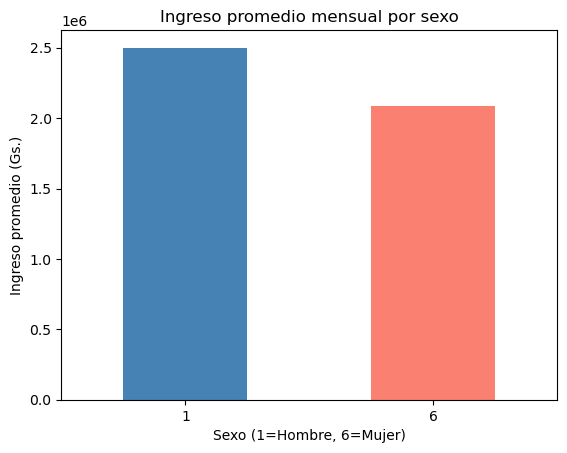

In [116]:
# Gráfico de barras
promedios.plot(kind="bar", color=["steelblue", "salmon"])
plt.title("Ingreso promedio mensual por sexo")
plt.xlabel("Sexo (1=Hombre, 6=Mujer)")
plt.ylabel("Ingreso promedio (Gs.)")
plt.xticks(rotation=0)  # deja las etiquetas horizontales
plt.show()

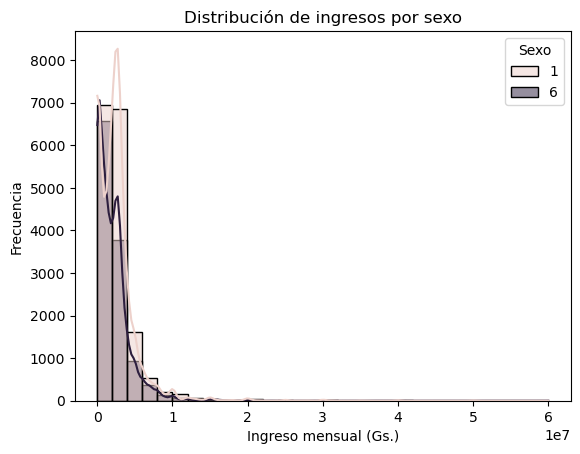

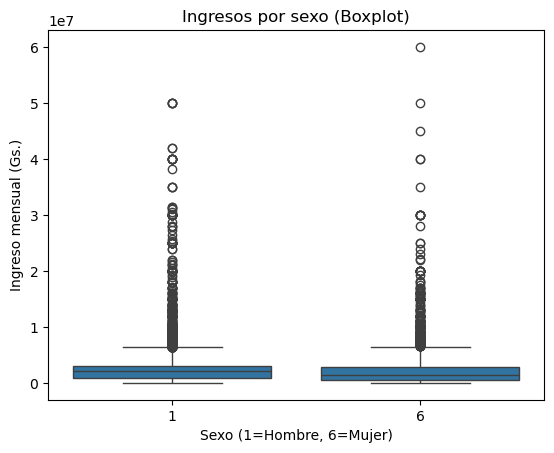

In [112]:
# Histograma con colores por sexo
sns.histplot(data=datos_filtrados, x="Ingreso", hue="Sexo", bins=30, kde=True)
plt.title("Distribución de ingresos por sexo")
plt.xlabel("Ingreso mensual (Gs.)")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot comparativo
sns.boxplot(data=datos_filtrados, x="Sexo", y="Ingreso")
plt.title("Ingresos por sexo (Boxplot)")
plt.xlabel("Sexo (1=Hombre, 6=Mujer)")
plt.ylabel("Ingreso mensual (Gs.)")
plt.show()

Aca se puede ver como en promedio los hombres ganan mas que las mujeres. Aunque en el gráfico de bloxplot se observan valores atipicos mas altos para las mujeres.

## Contrastar hipotesis

Podemos aplicar una prueba paramétrica (T-Student) o no paramétrica (Mann-Whitney U) si los datos no son normales.

A simple vista en el gráfico de distribución de ingresos por sexo ya se puede ver que no siguen una distribución normal. De todos modos para comprobarlo analiticamente vamos a hacer la prueba de Kolmogorov Smirnov

In [121]:
# Separar hombres y mujeres
hombres = datos_filtrados[datos_filtrados["Sexo"] == 1]["Ingreso"]
mujeres = datos_filtrados[datos_filtrados["Sexo"] == 6]["Ingreso"]

# --- 1. Test de normalidad Kolmogorov-Smirnov ---
# Normalizamos cada grupo (media=0, desvío=1) para comparar contra N(0,1)
def ks_normalidad(serie):
    serie = (serie - serie.mean()) / serie.std(ddof=0)
    return kstest(serie, "norm")

ks_hombres = ks_normalidad(hombres)
ks_mujeres = ks_normalidad(mujeres)

print("Kolmogorov-Smirnov hombres:", ks_hombres.pvalue)
print("Kolmogorov-Smirnov mujeres:", ks_mujeres.pvalue)

Kolmogorov-Smirnov hombres: 0.0
Kolmogorov-Smirnov mujeres: 0.0


Ambos pvalues salieron 0 < 0.05. Lo que demuestra analiticamente que no es una distribucion normal.

Entonces debemos aplicar el test Mann-Whithney U.

In [123]:
u_stat, p_val = mannwhitneyu(hombres, mujeres, alternative="two-sided")
print("U =", u_stat, "p =", p_val)

U = 109719508.5 p = 1.3619915489850995e-58


Para alpha = 0.05.

Si p < alpha se rechaza H0.

Si p > alpha no se rechaza H0.

En este caso p < alpha, por lo que se rechaza H0. Si hay diferencias significativas entre ingresos de hombres y mujeres.

# Conclusión

Si hay una diferencia significativa entre ingresos de hombres y mujeres.